# **Applying MLP on a synthetic dataset**

## **Imports**

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn

from sklearn.model_selection import train_test_split

%matplotlib inline

## **Synthesizing a binary classification dataset based on the given requirements**

In [2]:
# No. of data points
n_samples = 200

# No. of features (dimensions of the data)
n_features = 5

# No. of redundent features (linear combinations of other features)
n_redundant = 1

# No. of classes
n_classes = 2

X, y = sklearn.datasets.make_classification(n_samples=n_samples, n_features=n_features,
                                            n_redundant=n_redundant, n_classes=n_classes)

In [4]:
type(X), type(y)

(numpy.ndarray, numpy.ndarray)

In [5]:
X.shape, y.shape

((200, 5), (200,))

In [13]:
# Creating a dataframe out of it
df = pd.DataFrame(X, columns=['feature1', 'feature2', 'feature3', 'feature4', 'feature5'])

In [14]:
df['label'] = y

In [15]:
df.head()

,feature1,feature2,feature3,feature4,feature5,label
0,-0.864871,-0.922263,-0.883179,-0.811887,-0.026379,0
1,0.215277,-0.722364,-1.367748,-0.789241,-0.487629,0
2,-1.409372,0.791232,1.567580,0.880235,0.369602,1
3,-0.626224,0.277193,-0.444951,0.082887,1.251135,1
4,0.678845,-1.852525,0.081401,-1.209971,0.679288,0


##### **Lets visualize our data before proceeding**

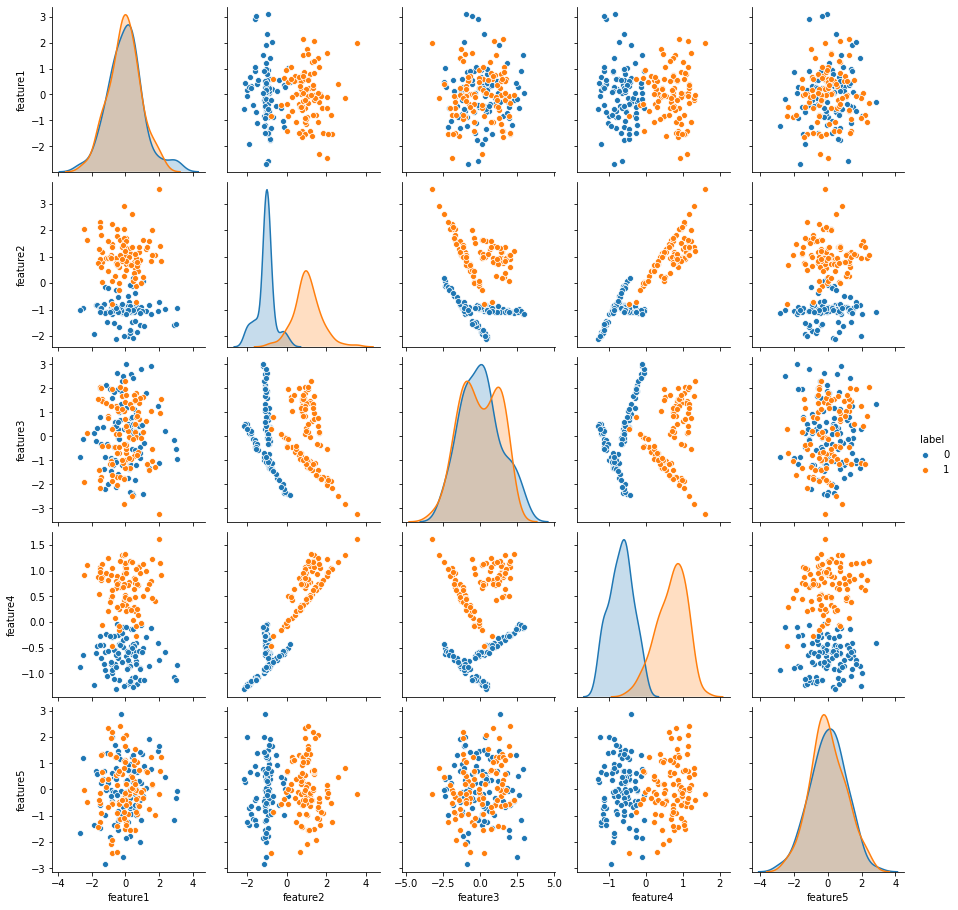

In [40]:
sns.pairplot(df, hue="label")

There's a decent amount of linear seperability in features 2 & 4 and the data follows gaussian distribution.

Thus, a simple 2 layer perceptron should give pretty good results.

In [41]:
df.to_csv('./data/synthetic.csv', index=False)

## **MLP From Scratch**

### **Architecture**

In [167]:
architecture = [
    {'input_dim': 5, 'output_dim': 7, 'activation': 'relu'}, # Input layer, thus, input_dim=5
    {'input_dim': 7, 'output_dim': 7, 'activation': 'relu'}, # Hidden layer
    {'input_dim': 7, 'output_dim': 1, 'activation': 'sigmoid'}  # Output layer
]

This is a very complex network for the simple linearly seperable data we have, but
it should work just fine.

Though the hidden layer can be removed without any effect on performance.

### **Initializing layers**

In [84]:
def init_layers(architecture):
    no_of_layers = len(architecture)
    params = {}
    
    for index, layer in enumerate(architecture):
        layer_index = index + 1
        layer_input_size = layer['input_dim']
        layer_output_size = layer['output_dim']
        
        params['W' + str(layer_index)] = np.random.randn(layer_output_size,
                                                               layer_input_size) * 0.1
        params['b' + str(layer_index)] = np.random.randn(layer_output_size, 1) * 0.1
        
    return params

### **Activation functions**

#### **Sigmoid**

![Sigmoid](images/sigmoid.png)

In [43]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

#### **Derivative of sigmoid**

![Sigmoid Derivative](images/sigmoid_derivative.png)

In [44]:
# dA is the activation

def sigmoid_derivative(dA, x):
    sig = sigmoid(x)
    return dA * sig * (1 - sig)

#### **RelU**

![RelU](images/relu.png)

In [46]:
def relu(x):
    return np.maximum(0, x)

#### **RelU derivative**

![RelU Derivative](images/relu_derivative.png)

In [47]:
def relu_derivative(dA, x):
    dZ = np.array(dA, copy=True)
    dZ[x <= 0] = 0
    return dZ

### **Forward Propogation**

#### **Single Layer Forward Propogation**

In [242]:
def single_layer_forward_propogation(A_prev, W_curr, b_curr, activation="relu"):
    Z_curr = np.dot(W_curr, A_prev) + b_curr
    if activation == 'relu':
        activation_function = relu
    elif activation == 'sigmoid':
        activation_function = sigmoid
    else:
        raise Exception("Activation function error")
        
    A_curr = activation_function(Z_curr)
    
    return A_curr, Z_curr

#### **Combined forward propogation**

In [52]:
def forward_propogation(X, params, architecture):
    memory = {}
    A_curr = X
    
    for index, layer in enumerate(architecture):
        layer_index = index + 1
        A_prev = A_curr
        
        current_activation_function = layer['activation']
        W_curr = params['W' + str(layer_index)]
        b_curr = params['b' + str(layer_index)]
        A_curr, Z_curr = single_layer_forward_propogation(A_prev, W_curr, b_curr,
                                                          current_activation_function)
        
        memory['A' + str(index)] = A_prev
        memory['Z' + str(layer_index)] = Z_curr
        
    return A_curr, memory

### **Loss Function**

In [174]:
def loss_function(y_hat, y):
    m = y_hat.shape[1]
    loss = -(1 / m) * (np.dot(y, np.log(y_hat).T) + np.dot(1-y, np.log(1-y_hat).T))
    return np.squeeze(loss)

### **Accuracy function**

In [185]:
def accuracy_function(y_hat, y):
    y_hat = np.round(y_hat)
    return (y_hat == y).all(axis=0).mean()

### **Single Layer BackPropogation**

In [141]:
def single_layer_backpropogation(dA_curr, W_curr, b_curr, Z_curr, A_prev, activation='relu'):
    m = A_prev.shape[1]
    
    if activation == 'relu':
        backward_activation_function = relu_derivative
    elif activation == 'sigmoid':
        backward_activation_function = sigmoid_derivative
        
    dZ_curr = backward_activation_function(dA_curr, Z_curr)
    dW_curr = np.dot(dZ_curr, A_prev.T) / m
    db_curr = np.sum(dZ_curr, axis=1, keepdims=True) / m
    dA_prev = np.dot(W_curr.T, dZ_curr)
    
    return dA_prev, dW_curr, db_curr

### **BackPropogation**

In [109]:
def backpropogation(y_hat, y, memory, params, architecture):
    gradients = {}
    y = y.reshape(y_hat.shape)
    
    dA_prev = -(np.divide(y, y_hat) - np.divide(1-y, 1-y_hat))
    
    for layer_index_prev, layer in reversed(list(enumerate(architecture))):
        layer_index_curr = layer_index_prev + 1
        activation_function_current = layer['activation']
        
        dA_curr = dA_prev
        
        A_prev = memory['A' + str(layer_index_prev)]
        Z_curr = memory['Z' + str(layer_index_curr)]
        W_curr = params['W' + str(layer_index_curr)]
        b_curr = params['b' + str(layer_index_curr)]
        
        dA_prev, dW_curr, db_curr = single_layer_backpropogation(dA_curr, W_curr, 
                                                                b_curr, Z_curr, 
                                                                A_prev,
                                                                activation_function_current)
        
        gradients['dW' + str(layer_index_curr)] = dW_curr
        gradients['db' + str(layer_index_curr)] = db_curr
        
    return gradients

### **Updating the trainable parameters**

In [149]:
def update(params, gradients, architecture, lr):
    for index, layer in enumerate(architecture):
        index += 1
        params['W' + str(index)] -= lr * gradients['dW' + str(index)]
        params['b' + str(index)] -= lr * gradients['db' + str(index)]
    return params

## **Training**

In [268]:
def train(X, y, architecture, epochs, lr):
    params = init_layers(architecture)
    loss_history = []
    accuracy_history = []
    
    for i in range(epochs):
        y_hat, memory = forward_propogation(X, params, architecture)        
        loss = loss_function(y_hat, y)
        loss_history.append(loss)
        accuracy = accuracy_function(y_hat, y)
        accuracy_history.append(accuracy)
        
        if i % 500 == 0:
            print('---------- EPOCH %d -------------' %i)
            print('Training accuracy: %.3f' %accuracy)
            print('Training loss: %.3f\n\n' %loss)
        
        gradients = backpropogation(y_hat, y, memory, params, architecture)
        params = update(params, gradients, architecture, lr)
        
    return params, loss_history, accuracy_history

In [269]:
X = np.array(X)
y = np.array(y)

In [271]:
results = train(X.T, y, architecture, 7000, 1e-2)

---------- EPOCH 0 -------------
Training accuracy: 0.500
Training loss: 0.694


---------- EPOCH 500 -------------
Training accuracy: 0.505
Training loss: 0.693


---------- EPOCH 1000 -------------
Training accuracy: 0.810
Training loss: 0.691


---------- EPOCH 1500 -------------
Training accuracy: 0.905
Training loss: 0.674


---------- EPOCH 2000 -------------
Training accuracy: 0.970
Training loss: 0.451


---------- EPOCH 2500 -------------
Training accuracy: 0.980
Training loss: 0.229


---------- EPOCH 3000 -------------
Training accuracy: 0.985
Training loss: 0.157


---------- EPOCH 3500 -------------
Training accuracy: 0.985
Training loss: 0.123


---------- EPOCH 4000 -------------
Training accuracy: 0.985
Training loss: 0.104


---------- EPOCH 4500 -------------
Training accuracy: 0.990
Training loss: 0.092


---------- EPOCH 5000 -------------
Training accuracy: 0.990
Training loss: 0.083


---------- EPOCH 5500 -------------
Training accuracy: 0.990
Training loss: 0.07

In [272]:
results[2][-5:]

[0.99, 0.99, 0.99, 0.99, 0.99]